In [44]:
import numpy as np
import cv2 as cv
from skimage.io import imread
import matplotlib.pyplot as plt

In [45]:
image1 = imread('images/im1.png')
image2 = imread('images/im2.png')
image1_gray = cv.cvtColor(image1,cv.COLOR_BGR2GRAY)
image2_gray = cv.cvtColor(image2,cv.COLOR_BGR2GRAY)

In [46]:
def get_keypoints_sift(image):
    gray= cv.cvtColor(image,cv.COLOR_BGR2GRAY)
    sift = cv.SIFT_create()
    kp,ds = sift.detectAndCompute(gray,None)
    return kp,ds

In [47]:
kp1,ds1 = get_keypoints_sift(image1)
kp2,ds2 = get_keypoints_sift(image2)

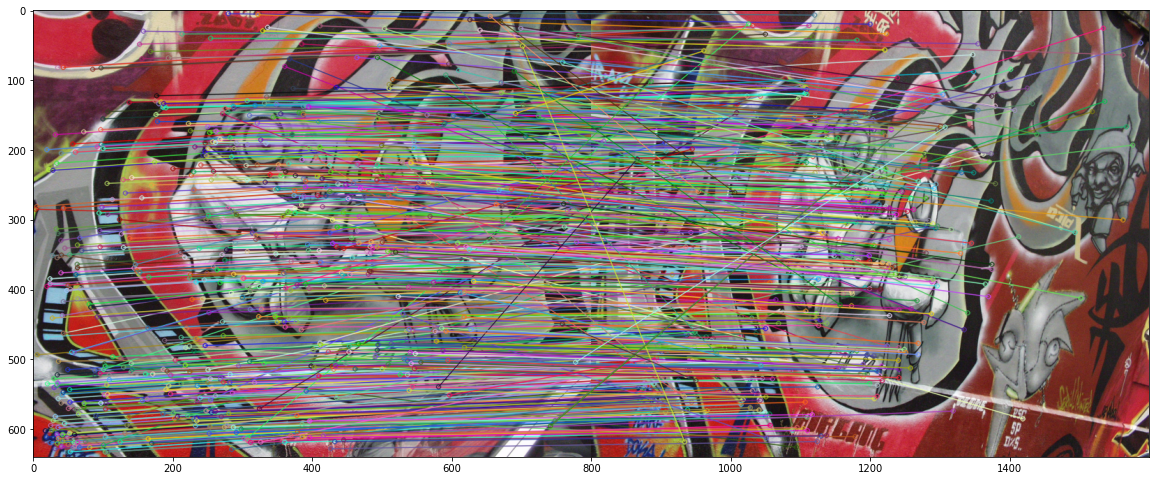

(<matplotlib.image.AxesImage at 0x7f6f8faae550>, None)

In [48]:
bf = cv.BFMatcher()
matches = bf.knnMatch(ds1,ds2,k=2)
# Apply ratio test
good = []
pts1 = []
pts2 = []
###ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        good.append([m])
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
img3 = cv.drawMatchesKnn(image1,kp1,image2,kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (20,20))
plt.imshow(img3),plt.show()

In [49]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)
# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

In [50]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

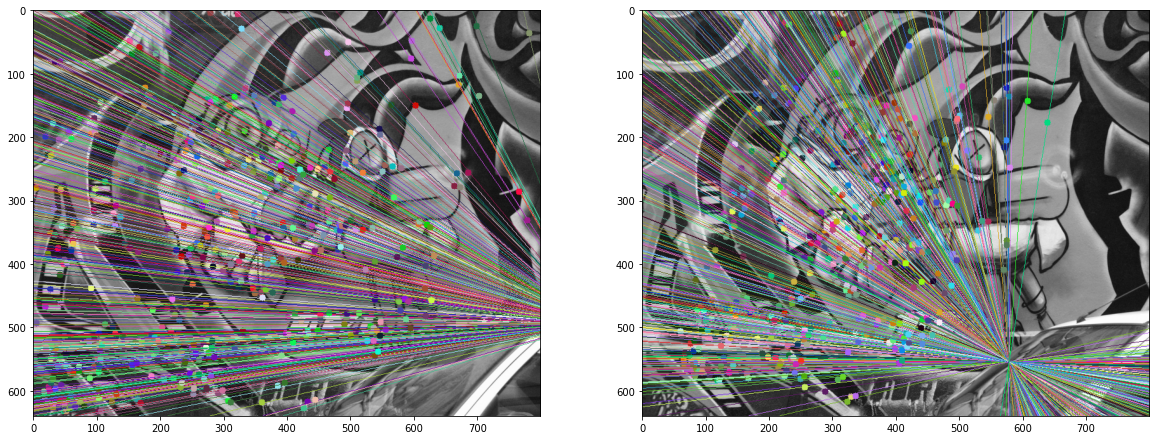

In [51]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(image1_gray,image2_gray,lines1,pts1,pts2)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(image1_gray,image2_gray,lines2,pts2,pts1)
plt.figure(figsize = (20,20))
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

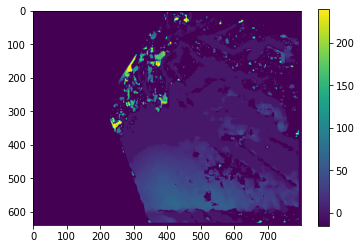

In [57]:
############## Stereo rectify uncalibrated ##############
h1, w1 = image1_gray.shape
h2, w2 = image2_gray.shape
thresh = 0
_, H1, H2 = cv.stereoRectifyUncalibrated(
    np.float32(pts1), np.float32(pts2), F, imgSize=(w1, h1), threshold=thresh,
)

############## Undistort (Rectify) ##############
imgL_undistorted = cv.warpPerspective(image1_gray, H1, (w1, h1))
imgR_undistorted = cv.warpPerspective(image2_gray, H2, (w2, h2))
cv.imwrite("images/undistorted_L.png", imgL_undistorted)
cv.imwrite("images/undistorted_R.png", imgR_undistorted)

############## Calculate Disparity (Depth Map) ##############

stereo = cv.StereoBM_create(numDisparities=16, blockSize=15)
disparity_BM = stereo.compute(imgL_undistorted, imgR_undistorted)
plt.imshow(disparity_BM, )
plt.colorbar()
plt.show()